In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier


In [8]:
# Loadng the  CSVs
base_path = r"C:\Users\yashb\Desktop\Heart Failure Readmission Prediction\mimic-iii-clinical-database-demo-1.4\mimic-iii-clinical-database-demo-1.4"

admissions = pd.read_csv(base_path + "/ADMISSIONS.csv")
diagnoses = pd.read_csv(base_path + "/DIAGNOSES_ICD.csv")
patients = pd.read_csv(base_path + "/PATIENTS.csv")

In [9]:
#  Filtering  for heart failure ICD-9 codes
heart_failure_icd9 = {
    '39891','40201','40211','40291','40401','40403','40411','40413',
    '40491','40493','4280','4281','42820','42821','42822','42823',
    '42830','42831','42832','42833','42840','42841','42842','42843','4289'
}

In [10]:
hf_diagnoses = diagnoses[diagnoses['icd9_code'].isin(heart_failure_icd9)]
hf_admissions = pd.merge(hf_diagnoses, admissions, on=['subject_id', 'hadm_id'])


In [11]:
#  Converting the  date columns
hf_admissions['admittime'] = pd.to_datetime(hf_admissions['admittime'])
hf_admissions['dischtime'] = pd.to_datetime(hf_admissions['dischtime'])

In [12]:
#  Labeling the  readmission within 30 days
hf_admissions = hf_admissions.sort_values(by=['subject_id', 'admittime'])

hf_admissions['next_admit'] = hf_admissions.groupby('subject_id')['admittime'].shift(-1)
hf_admissions['readmit_gap'] = (hf_admissions['next_admit'] - hf_admissions['dischtime']).dt.days
hf_admissions['readmit_30d'] = hf_admissions['readmit_gap'].apply(lambda x: 1 if pd.notnull(x) and 0 < x <= 30 else 0)

In [13]:
#  Feature Engineering
# And  Adding the  patient demographics
patients['dob'] = pd.to_datetime(patients['dob'])
hf_admissions = pd.merge(hf_admissions, patients[['subject_id', 'gender', 'dob']], on='subject_id', how='left')


In [14]:
# Convert to datetime with error coercion
hf_admissions['admittime'] = pd.to_datetime(hf_admissions['admittime'], errors='coerce')
hf_admissions['dob'] = pd.to_datetime(hf_admissions['dob'], errors='coerce')

# Drop rows where date parsing failed
hf_admissions = hf_admissions.dropna(subset=['admittime', 'dob'])

# Define safe age calculation
def safe_age(row):
    try:
        age = (row['admittime'] - row['dob']).days // 365
        if 0 <= age <= 120:
            return age
    except:
        pass
    return None

# Apply safe function row-wise
hf_admissions['age'] = hf_admissions.apply(safe_age, axis=1)

#  Drop rows where age couldn't be calculated
hf_admissions = hf_admissions.dropna(subset=['age'])

# Converting  age to integer
hf_admissions['age'] = hf_admissions['age'].astype(int)


In [15]:
# Encode gender (robust)
gender_col = [col for col in hf_admissions.columns if col.upper() == 'GENDER']
if gender_col:
    hf_admissions['gender'] = hf_admissions[gender_col[0]].map({'M': 1, 'F': 0})
else:
    raise KeyError("❌ 'GENDER' column not found after merging. Please verify column names.")


In [16]:
# Normalizing the  column names to uppercase to prevent KeyErrors
hf_admissions.columns = hf_admissions.columns.str.upper()


In [17]:
hf_admissions = hf_admissions.sort_values(by=['SUBJECT_ID', 'ADMITTIME'])


In [18]:
hf_admissions['next_admit'] = hf_admissions.groupby('SUBJECT_ID')['ADMITTIME'].shift(-1)
hf_admissions['days_to_next'] = (hf_admissions['next_admit'] - hf_admissions['DISCHTIME']).dt.days


In [19]:
hf_admissions['readmitted_30days'] = hf_admissions['days_to_next'].apply(
    lambda x: 1 if pd.notna(x) and 0 <= x <= 30 else 0
)


In [20]:
model_data = hf_admissions[['SUBJECT_ID', 'HADM_ID', 'AGE', 'GENDER', 'ADMITTIME', 'DISCHTIME', 'readmitted_30days']]


In [21]:
#  Saving to CSV
model_data.to_csv("heart_failure_readmissions_cleaned.csv", index=False)

print("✅ Data processing complete. Final shape:", model_data.shape)

✅ Data processing complete. Final shape: (58, 7)


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [23]:
X = model_data.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'readmitted_30days'])

# Features and target
y = model_data['readmitted_30days']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:

X = model_data.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'readmitted_30days'])


y = model_data['readmitted_30days']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=1)  # Reduced from 5 to 1
X_resampled, y_resampled = smote.fit_resample(X, y)

# Now split and proceed
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [26]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8636363636363636
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.90      0.82      0.86        11

    accuracy                           0.86        22
   macro avg       0.87      0.86      0.86        22
weighted avg       0.87      0.86      0.86        22

Confusion Matrix:
 [[10  1]
 [ 2  9]]


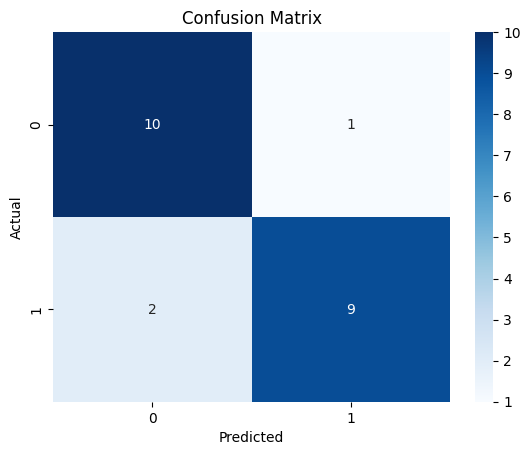

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


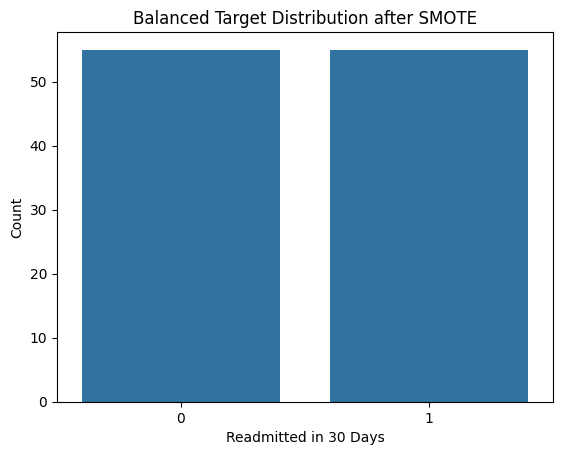

In [22]:
sns.countplot(x=y_resampled)
plt.title("Balanced Target Distribution after SMOTE")
plt.xlabel("Readmitted in 30 Days")
plt.ylabel("Count")
plt.show()


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    classification_report
)

In [25]:
# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

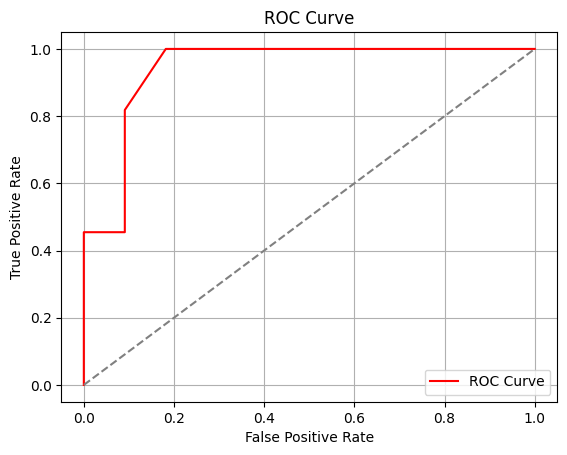

In [26]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Readmission", "Readmission"]))

Classification Report:
                precision    recall  f1-score   support

No Readmission       0.83      0.91      0.87        11
   Readmission       0.90      0.82      0.86        11

      accuracy                           0.86        22
     macro avg       0.87      0.86      0.86        22
  weighted avg       0.87      0.86      0.86        22



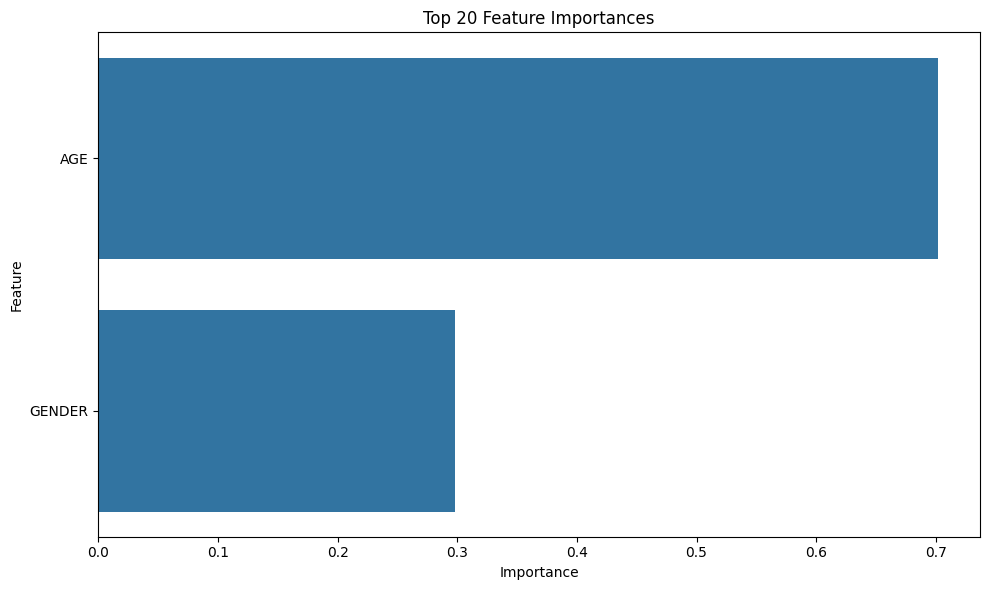

In [28]:
#Feature importance
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    feature_names = X_test.columns
    feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20))
    plt.title("Top 20 Feature Importances")
    plt.tight_layout()
    plt.show()

In [29]:
def predict_readmission(new_data, model, feature_columns):
    """
    Predict readmission for new patient data.
    
    Parameters:
    - new_data: DataFrame containing new patient data
    - model: trained model object
    - feature_columns: list of columns used in training
    
    Returns:
    - DataFrame with prediction and probability
    """
    input_data = new_data[feature_columns]
    prediction = model.predict(input_data)
    probability = model.predict_proba(input_data)[:, 1]
    
    result = new_data.copy()
    result['Readmission_Prediction'] = prediction
    result['Readmission_Probability'] = probability
    
    return result
